In [436]:
import numpy as np
import tensorflow as tf
from stochastic.processes.continuous import FractionalBrownianMotion
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [549]:
def gen_fbm_track(ntimes, hurst_const=None, initial_position=[0,0,0]):
                              
    if hurst_const == None:
        hurst_exp = np.random.uniform(0.,1.)
    else:
        hurst_exp = hurst_const
    fbm = FractionalBrownianMotion(hurst=hurst_exp,t=1,rng=None)
    x = fbm.sample(ntimes)
    y = fbm.sample(ntimes)
    z = fbm.sample(ntimes)
    
    r = np.sqrt((np.amax(x)-np.amin(x))**2 + (np.amax(y)-np.amin(y))**2 + (np.amax(z)-np.amin(z))**2) 
    
    dx = (x[1:]-x[0:-1])/(np.amax(x)-np.amin(x))#r
    dy = (y[1:]-y[0:-1])/(np.amax(y)-np.amin(y))#r
    dz = (z[1:]-z[0:-1])/(np.amax(z)-np.amin(z))#r
    
    #dx = (x[1:]-x[0:-1])*hurst_exp
    #dy = (y[1:]-y[0:-1])*hurst_exp
    #dz = (z[1:]-z[0:-1])*hurst_exp
    
    x_norm = np.append(np.array([0]),np.cumsum(dx))
    y_norm = np.append(np.array([0]),np.cumsum(dy))
    z_norm = np.append(np.array([0]),np.cumsum(dz))

    x0, y0, z0 = initial_position
    #x, y, z = x+x0,y+y0,z+z0#
    x, y, z = x_norm+x0, y_norm+y0, z_norm+z0
        
    return x, y, z

def get_exit_index(xs, ys, radius):
    #input entire track
    i = 0
    index = None
    
    while i<len(xs):
        if xs[i]**2 + ys[i]**2 > radius**2:
            index = i
            break 
        i+=1 
        
    return index

def track_until_collision(xs, ys, zs, radius):
    #input entire track
    i = get_exit_index(xs, ys, radius)
#     if index==None:  #does not exit
#         i = len(xs)  #keep entire track
#     else:
#         i = index
    xs = xs[:i]
    ys = ys[:i]
    zs = zs[:i]
    return xs, ys, zs

def split_track_at_collision(xs, ys, zs, radius):
    #input entire track
    i = get_exit_index(xs, ys, radius)
#     if index==None:  #does not exit
#         i = len(xs)  #keep entire track
#     else:
#         i = index
    xs_before = xs[:i]
    ys_before = ys[:i]
    zs_before = zs[:i]
    xs_after = xs[i:]
    ys_after = ys[i:]
    zs_after = zs[i:]
    return (xs_before, ys_before, zs_before), (xs_after, ys_after, zs_after)

# def exit_check(xs, ys, radius):
#     #input entire track
#     index = get_exit_index(xs, ys, radius)
#     if index!=None:
#         return True
#     else:
#         return False
    
def exit_check(xs, ys, radius):
    #input entire track
    for i in range(len(xs)):
        if xs[i]**2 + ys[i]**2 > radius**2:
            exit_info = 'exit'
            break
        else:
            exit_info = 'no exit'
            
    return exit_info

def get_exit_step(xs, ys, zs, radius):
    #input entire track
    i = get_exit_index(xs, ys, radius)
    dx = xs[i+1]-xs[i]
    dy = ys[i+1]-ys[i]
    dz = zs[i+1]-zs[i]
    return dx, dy, dz

def get_exit_vector(xs_exit, ys_exit, zs_exit):
    
    dx = xs_exit[1]-xs_exit[0]
    dy = ys_exit[1]-ys_exit[0]
    dz = zs_exit[1]-zs_exit[0]
    return dx, dy, dz

def get_exit_coords(xs, ys, zs, radius):
    #input entire track
    i = get_exit_index(xs, ys, radius)
    xs_exit = xs[i-1:i+1]
    ys_exit = ys[i-1:i+1]
    zs_exit = zs[i-1:i+1]
    return xs_exit, ys_exit, zs_exit

def get_exit_vector(xs_exit, ys_exit, zs_exit, r):
    
    dx = xs_exit[1]-xs_exit[0]
    dy = ys_exit[1]-ys_exit[0]
    dz = zs_exit[1]-zs_exit[0]
    return dx, dy, dz
    
def get_intersection_point(xs_exit, ys_exit, zs_exit, r):
    
    x1,x2 = xs_exit
    y1,y2 = ys_exit
    z1,z2 = zs_exit
    
    dx, dy, dz = get_exit_vector(xs_exit, ys_exit, zs_exit, r)
    
    #parameterize to get quadratic in t, at^2+bt+c=0
    a = dx**2 + dy**2
    b = 2*x1*dx + 2*y1*dy
    c = x1**2 + y1**2 - r**2
    
    #solve to get two roots
    t_roots = np.roots([a,b,c])
    x_roots = x1 + t_roots*dx
    y_roots = y1 + t_roots*dy
    z_roots = z1 + t_roots*dz
    
    #choose root that corresponds to the exit point
    i = np.argmin((x2-x_roots)**2+(y2-y_roots)**2)
    
    return x_roots[i], y_roots[i], z_roots[i]

def get_mod(v):
    
    return np.sqrt(np.dot(v,v))

def get_exit_angle(xs_exit, ys_exit, zs_exit, r):
    
    x_intersection, y_intersection = get_intersection_point(xs_exit, ys_exit, zs_exit, r)[:2]
    r_vector = np.array([x_intersection, y_intersection])
    exit_vector = get_exit_vector(xs_exit, ys_exit, zs_exit, r)[:2]  #taking only first two elements, ignoring z
    
    rmod = get_mod(r_vector)
    exit_mod = get_mod(exit_vector)
    
    cos_theta = np.dot(r_vector,exit_vector)/(rmod*exit_mod)
    
    return np.arccos(cos_theta)

def get_acw_rotation_angle(xs_exit, ys_exit, zs_exit, r):

    x_intersection, y_intersection = get_intersection_point(xs_exit, ys_exit, zs_exit, r)[:2]
    r_vector = np.array([x_intersection, y_intersection])
    exit_vector = get_exit_vector(xs_exit, ys_exit, zs_exit, r)[:2]  #taking only first two elements, ignoring z
    
    theta = get_exit_angle(xs_exit, ys_exit, zs_exit, r)
    rot_angle = np.pi-2*theta
    if np.cross(r_vector, exit_vector) > 0:
        return rot_angle
    else:
        return -rot_angle

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return qx, qy

def gen_fbm_track_with_reflection(hurst_exp, radius, ntimes, initial_pos=(0,0,0)):
    
    #generate entire track
    data_x, data_y, data_z = gen_fbm_track(ntimes, hurst_exp, initial_pos)
    
    #keep going if track exits cylinder
    #keep_going = exit_check(data_x, data_y, radius)
    collision_points = np.array([0,0,0])
    collision_counter = 0
    while exit_check(data_x, data_y, radius)=='exit':
        
        xs_exit, ys_exit, zs_exit = get_exit_coords(data_x, data_y, data_z, radius)
        collision_xyz = get_intersection_point(xs_exit, ys_exit, zs_exit, radius)
        collision_points = np.vstack((collision_points, collision_xyz))
        x_coll, y_coll, z_coll = collision_xyz
        collision_counter += 1
        print('Collision counter: {}'.format(collision_counter))
        
        acw_rot_angle = get_acw_rotation_angle(xs_exit, ys_exit, zs_exit, radius)
        
        (xs_before, ys_before, zs_before), (xs_after, ys_after, zs_after) = split_track_at_collision(data_x, data_y, data_z,
                                                                                                     radius)
        xs_after_rot, ys_after_rot = rotate([x_coll, y_coll], [xs_after, ys_after], acw_rot_angle)
        
        data_x = np.concatenate((xs_before, x_coll, xs_after_rot), axis=None)
        data_y = np.concatenate((ys_before, y_coll, ys_after_rot), axis=None)
        data_z = np.concatenate((zs_before, z_coll, zs_after), axis=None)  # z unchanged
        
        #keep_going = exit_check(data_x, data_y, radius)
        
    return data_x, data_y, data_z, collision_points[1:]

# def gen_fbm_track_new(hurst_exp, radius, ntimes, initial_pos=[0,0,0]):
    
#     data_x, data_y, data_z = np.array([]), np.array([]), np.array([])
#     initial_positions = np.array([initial_pos])
#     collision_counter = 0
    
#     while len(data_x) < ntimes:
    
#         initial_point = initial_positions[-1]
#         #new track will include the collision point as its first point
#         xs, ys, zs = gen_fbm_track(ntimes, hurst_exp, initial_point)
        
#         #remove first point for now
#         xs, ys, zs = xs[1:], ys[1:], zs[1:]
        
#         if exit_check(xs, ys, radius)=='exit':
            
#             xs_exit, ys_exit, zs_exit = get_exit_coords(xs, ys, zs, radius)
#             print(xs_exit, ys_exit, zs_exit)
#             collision_xyz = get_intersection_point(xs_exit, ys_exit, zs_exit, radius)
            
#             if not (collision_xyz==initial_positions).all():
                
#                 initial_positions = np.vstack((initial_positions, collision_xyz))
#                 collision_counter += 1
#                 print('Collision counter: {}'.format(collision_counter))
#                 xs, ys, zs = track_until_collision(xs, ys, zs, radius)
        
#         data_x = np.append(data_x, initial_point[0])
#         data_x = np.append(data_x, xs)
#         data_y = np.append(data_y, initial_point[1])
#         data_y = np.append(data_y, ys)
#         data_z = np.append(data_z, initial_point[2])
#         data_z = np.append(data_z, zs)
        
#     collision_points = initial_positions[1:]
#     data_x, data_y, data_z = data_x[:ntimes], data_y[:ntimes], data_z[:ntimes]
    
#     return data_x, data_y, data_z, collision_points

def gen_fbm_track_collisions(hurst_exp, radius, ntimes, initial_pos=(0,0,0)):
    
    data_x, data_y, data_z = gen_fbm_track(ntimes, hurst_exp, initial_pos)
    
    data_x, data_y, data_z = track_until_reflection(data_x, data_y, data_z, radius)
    
    initial_pos_array = np.array([0,0,0])
    
    collision_counter = 0
    
    while len(data_x) < ntimes:
        
        new_initial_pos = (data_x[-1], data_y[-1], data_z[-1])
        
        x, y, z = gen_fbm_track(ntimes, hurst_exp, initial_position=new_initial_pos)
    
        new_x = np.append(data_x, x)
        new_y = np.append(data_y, y)
        new_z = np.append(data_z, z)
        
        new_data_x, new_data_y, new_data_z = track_until_reflection(new_x, new_y, new_z, radius)
        
        #to avoid duplicates in initial_pos_array
        if new_data_x[-1]!=data_x[-1]:
            initial_pos_array = np.vstack((initial_pos_array, new_initial_pos))
            data_x, data_y, data_z = new_data_x, new_data_y, new_data_z
            collision_counter +=1
            print('Collision counter: ', collision_counter)
        
    data_x, data_y, data_z = data_x[:ntimes], data_y[:ntimes], data_z[:ntimes]

    return data_x, data_y, data_z, initial_pos_array[1:]

def gen_fbm_track_new(hurst_exp, radius, ntimes, initial_pos=(0,0,0)):
    
    # still needs work
    
    data_x, data_y, data_z = gen_fbm_track(ntimes, hurst_exp, initial_pos)
    
    xs_exit, ys_exit, zs_exit = get_exit_coords(data_x, data_y, data_z, radius)
    collision_xyz = get_intersection_point(xs_exit, ys_exit, zs_exit, radius)
    collision_points = collision_xyz
    
    data_x, data_y, data_z = track_until_reflection(data_x, data_y, data_z, radius)
    coll_indices = np.array([len(data_x)])
    
    initial_pos_array = np.array([0,0,0])
    
    collision_counter = 0
    
    while len(data_x) < ntimes:
        
        #new_initial_pos = (data_x[-1], data_y[-1], data_z[-1])
        new_initial_pos = collision_xyz
        
        x, y, z = gen_fbm_track(ntimes+1, hurst_exp, initial_position=new_initial_pos)
        
        #remove collision point for now, will add back in later
        x, y, z = x[1:], y[1:], z[1:]
        
        new_x = np.append(data_x, x)
        new_y = np.append(data_y, y)
        new_z = np.append(data_z, z)
        
        new_data_x, new_data_y, new_data_z = track_until_reflection(new_x, new_y, new_z, radius)
        
        #to avoid duplicates in initial_pos_array
        if new_data_x[-1]!=data_x[-1]:
            initial_pos_array = np.vstack((initial_pos_array, new_initial_pos))
            data_x, data_y, data_z = new_data_x, new_data_y, new_data_z
    
            collision_counter +=1
            print('Collision counter: ', collision_counter)
            
            xs_exit, ys_exit, zs_exit = get_exit_coords(new_x, new_y, new_z, radius)
            collision_xyz = get_intersection_point(xs_exit, ys_exit, zs_exit, radius)
            collision_points = np.vstack((collision_points, collision_xyz))
            coll_indices = np.append(coll_indices, len(data_x))
    
    #insert collision points
    coll_xs, coll_ys, coll_zs = np.transpose(collision_points)
    data_x = np.insert(data_x, coll_indices, coll_xs)
    data_y = np.insert(data_y, coll_indices, coll_ys)
    data_z = np.insert(data_z, coll_indices, coll_zs)
    
    data_x, data_y, data_z = data_x[:ntimes], data_y[:ntimes], data_z[:ntimes]
    coll_xs = coll_xs[np.where(np.isin(coll_xs, data_x))]
    coll_ys = coll_ys[np.where(np.isin(coll_ys, data_y))]
    coll_zs = coll_zs[np.where(np.isin(coll_zs, data_z))]
    coll_pts = np.transpose(np.concatenate(([coll_xs], [coll_ys], [coll_zs]), axis=0))

    return data_x, data_y, data_z, coll_pts

In [550]:
def plot_random_walk_single(axis, data_x, data_y, data_z, init_pos=[0,0,0]):
    
    axis.plot(data_x, data_y, data_z,color='k')
    axis.scatter(data_x[0], data_y[0], data_z[0], color='black')
    axis.scatter(data_x[-1], data_y[-1], data_z[-1], color='green')

In [551]:
def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(-height_z/2, height_z/2, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

def plot_cylinder_along_z(axis, center_x, center_y, radius, height_z):
    Xc,Yc,Zc = data_for_cylinder_along_z(center_x, center_y, radius, height_z)
    axis.plot_surface(Xc, Yc, Zc, alpha=0.1)
    axis.set_xlabel('x')
    axis.set_ylabel('y')
    axis.set_zlabel('z')
    axis.set_xlim(-1.5*radius, 1.5*radius)
    axis.set_ylim(-1.5*radius, 1.5*radius)
    #ax.set_zlim(-1.5*radius, 1.5*radius)

In [552]:
def get_rand_initial_pos(radius, z_lim=None):
    
    if z_lim==None:
        z_lim = [-radius, radius]
        
    x0, y0 = np.random.uniform(-radius, radius, 2)
    z0 = np.random.uniform(-z_lim[0], z_lim[1], 1)
    
    while x0**2+y0**2 > radius**2:
        x0, y0 = np.random.uniform(-radius, radius, 2)
        z0 = np.random.uniform(-z_lim[0], z_lim[1], 1)
    
    return x0, y0, z0

Collision counter:  1
Collision counter:  2
Collision counter:  3
Collision counter:  4
Collision counter:  5
Number of collisions: 5
[[-0.34981347 -0.35725417 -0.38457874]
 [-0.34538246 -0.3615397  -0.39645894]
 [-0.34655501 -0.3604159  -0.39345632]
 [-0.34296665 -0.36383221 -0.37232581]
 [ 0.44582925  0.22635433 -0.15979412]]


<IPython.core.display.Javascript object>


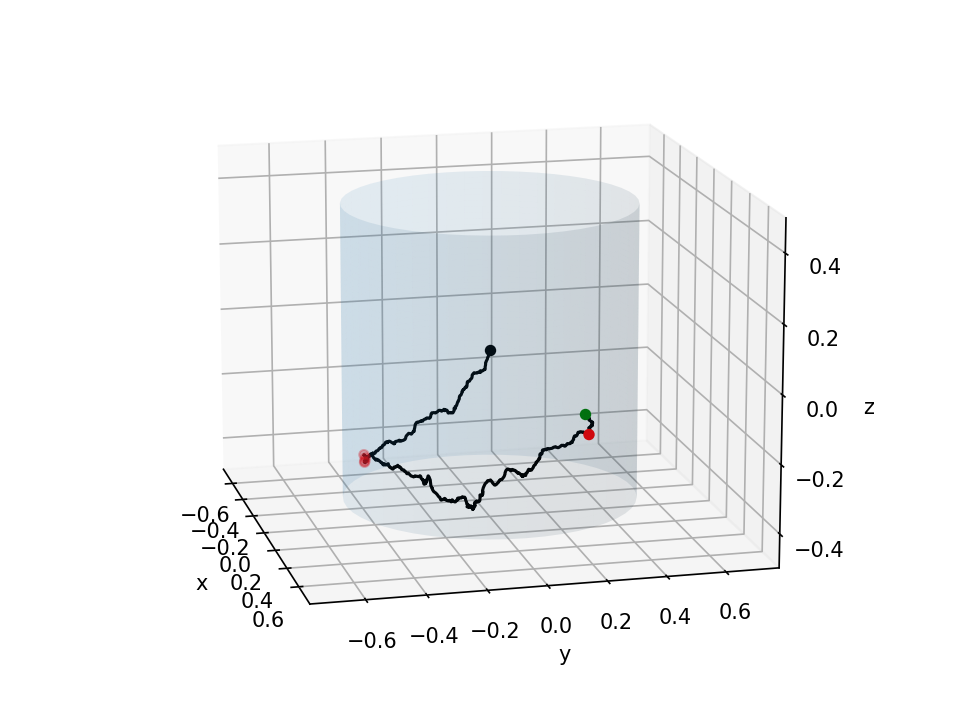

C:\Users\4mila\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  if sys.path[0] == '':


In [555]:
def plot_in_cylinder(h, r, ntimes, include_reflection=False, initial_pos=(0,0,0)):
    
    if include_reflection:
        data_x, data_y, data_z, coll_pts = gen_fbm_track_with_reflection(h, r, ntimes, initial_pos=initial_pos)
    else:
        #data_x, data_y, data_z, coll_pts = gen_fbm_track_collisions(h, r, ntimes, initial_pos=initial_pos)
        data_x, data_y, data_z, coll_pts = gen_fbm_track_new(h, r, ntimes, initial_pos=initial_pos)
    print('Number of collisions: {}'.format(len(coll_pts)))
    print(coll_pts)
    
    fig = plt.figure()
    ax = Axes3D(fig)
    #ax = fig.add_subplot(projection="3d")
    
    plot_random_walk_single(ax, data_x, data_y, data_z)
    plot_cylinder_along_z(ax, 0, 0, r, 2*np.max(np.abs(data_z)))
    try:
        ax.scatter(xs=coll_pts[:,0], ys=coll_pts[:,1], zs=coll_pts[:,2], color='r')
    except: IndexError
    
plot_in_cylinder(0.9, 0.5, 1000)

In [518]:
for h_value in [0.1, 0.5, 0.9]:
    pos_data = gen_fbm_track_collisions(h_value, 1, 1000, initial_pos=(0,0,0))
    print('for H = ', h_value)
    print('   number of positions: {}'.format(len(pos_data[0])))
    print('   average x step: {}'.format(np.mean(np.abs(np.diff(pos_data[0])))))
    print('   average y step: {}'.format(np.mean(np.abs(np.diff(pos_data[1])))))
    print('   average z step: {}'.format(np.mean(np.abs(np.diff(pos_data[2])))))
    print('   max x step: {}'.format(np.max(np.abs(np.diff(pos_data[0])))))
    print('   max y step: {}'.format(np.max(np.abs(np.diff(pos_data[1])))))
    print('   max z step: {}'.format(np.max(np.abs(np.diff(pos_data[2])))))

for H =  0.1
   number of positions: 1000
   average x step: 0.11221948146018418
   average y step: 0.10625388644737874
   average z step: 0.1076254896734342
   max x step: 0.45343494304489995
   max y step: 0.45725201428912604
   max z step: 0.46496995186826146
for H =  0.5
   number of positions: 1000
   average x step: 0.016844305366342485
   average y step: 0.01815477066952176
   average z step: 0.01898626521736865
   max x step: 0.0639850780064729
   max y step: 0.07893640829608845
   max z step: 0.0779079954040352
Collision counter:  1
Collision counter:  2
Collision counter:  3
Collision counter:  4
Collision counter:  5
Collision counter:  6
for H =  0.9
   number of positions: 1000
   average x step: 0.0015498916113753376
   average y step: 0.0032290691286802247
   average z step: 0.005764644362940831
   max x step: 0.007011985584108427
   max y step: 0.013261150911013486
   max z step: 0.02414720724765973


In [449]:
def gen_mc_fbm_cylinder_data(radius, track_length, mc_samples):
    
    for i in np.arange(mc_samples):
        
        track_id_arr = np.full((track_length,1),i, dtype=int)
        timestep_arr = np.arange(track_length,1)
    
        x,y,z,__ = gen_fbm_track_collisions(h, r, nsteps, initial_pos=(0,0,0))
        
        x = np.reshape(x_temp,(track_length,1))
        y = np.reshape(y_temp,(track_length,1))
        z = np.reshape(z_temp,(track_length,1))
        
        track_time_xyz_arr = np.hstack(track_id_arr,timestep_arr,x,y,z)
             

In [ ]:
def h_sine(t):
    
    h_val = 0.5+0.4*np.sin(2*np.pi*t)
    
    return h_val

def h_step(t):
    
    print(max(t))
    
    h_val = np.piecewise(t, [t < max(t)//2, t >= max(t)//2], 
                         [lambda t: (t)//max(t), lambda t: 1-t//max(t)])

    return h_val
 
#m = mbm(n=1000, hurst=h_step, length=100, method='riemannliouville')
t = times(n=1000,length=100)

In [ ]:
#plt.plot(t,m)
plt.plot(t,h_step(t))

def gen_fbm_data(nsamples, ntimes, hurst_const=None):
    """ 
    Function to produce fractional brownian motion data for neural network 
    training and testing
    Inputs: nsamples; number of samples, ntimes; number of times (= number of steps)
    Outputs: traindata; training data for NN, trainlabels; labels associated 
            with traindata
    """
    #data = np.empty((nsamples,ntimes+1,3))
    data_x = np.empty((nsamples,ntimes+1))
    data_y = np.empty((nsamples,ntimes+1))
    data_z = np.empty((nsamples,ntimes+1))
                              
    labels = np.empty((nsamples,1))
    for i in range(0,nsamples):
        if hurst_const == None:
            hurst_exp = np.random.uniform(0.,1.)
        else:
            hurst_exp = hurst_const
        fbm = FractionalBrownianMotion(hurst=hurst_exp,t=1,rng=None)
        x = fbm.sample(ntimes)
        y = fbm.sample(ntimes)
        z = fbm.sample(ntimes)
        #apply differencing and normalization on the data
        #dx = (x[1:]-x[0:-1])/(np.amax(x)-np.amin(x))
        #dy = (y[1:]-x[0:-1])/(np.amax(y)-np.amin(y))
        #dz = (z[1:]-x[0:-1])/(np.amax(z)-np.amin(z))
        #data[i,:] = np.array([x,y,z]).transpose()
        data_x[i,:] = x
        data_y[i,:] = y
        data_z[i,:] = z
        labels[i,:] = hurst_exp
        
    return data_x, data_y, data_z, labels


In [ ]:
# def gen_all_tracks(nsamples, ntimes, hurst_exp, radius, xy_centre=(0,0), height_z=None, initial_pos=None, plot=True):
    
#     data_x = np.empty((nsamples,ntimes+1))
#     data_y = np.empty((nsamples,ntimes+1))
#     data_z = np.empty((nsamples,ntimes+1))
    
#     for i in range(0, nsamples):
#         if initial_pos==None:
#             initial_pos = get_rand_initial_pos(radius)
#         data_x[i,:], data_y[i,:], data_z[i,:] = gen_fbm_track_collisions(hurst_exp, radius, ntimes, initial_pos=initial_pos)
        
#     if plot:
#         fig = plt.figure()
#         ax = Axes3D(fig, auto_add_to_figure=False)
#         fig.add_axes(ax)
#         if height_z==None:
#             height_z = 2*np.max(np.abs(data_z))
#         plot_cylinder_along_z(xy_centre[0], xy_centre[1], radius, height_z)
#         plot_random_walks(data_x, data_y, data_z)

# def track_until_reflection(xs, ys, zs, radius):
#     #input entire track
#     indices = np.argwhere(xs**2+ys**2>radius**2).ravel()
#     if len(indices)>0:
#         i = indices[0]
#         #print(indices)
#         xs = xs[:i]
#         ys = ys[:i]
#         zs = zs[:i]
#     return xs, ys, zs

# def exit_check(xs, ys, zs, radius):
#     #input entire track
#     indices = np.argwhere(xs**2+ys**2>radius**2).ravel()
#     if len(indices)>0:
#         return True
#     else:
#         return False

# def plot_random_walks(data_x, data_y, data_z):
    
#     for i in range(len(data_x)):  # plotting each track
#         ax.plot(data_x[i,:],data_y[i,:],data_z[i,:])

# def exit_coords(xs, ys, zs, radius):
#     #input entire track
#     indices = np.argwhere(xs**2+ys**2>radius**2).ravel()
#     if len(indices)>0:
#         i = indices[0]
#         xs = xs[i-1:i+1]
#         ys = ys[i-1:i+1]
#         zs = zs[i-1:i+1]
#     return xs, ys, zs

# def gradient(xs, ys):
#     # 2 elements in xs, 2 elements in ys
#     return (ys[1]-ys[0])/(xs[1]-xs[0])

# def get_roots(xs, ys, r):
#     # 2 elements in xs, 2 elements in ys
#     x1,x2 = xs
#     y1,y2 = ys
    
#     m = gradient(xs, ys)
#     a = m**2+1
#     b = 2*m*(y1-m*x1)
#     c = (m**2)*(x1**2) - 2*m*y1*x1 + y1**2 - r**2
    
#     x_roots = np.roots([a,b,c])
#     y_roots = m*(x_roots-x1)+y1
    
#     return x_roots, y_roots

# def get_intersection_xy(xs_exit, ys_exit, r):
#     # 2 elements in xs_exit, 2 elements in ys_exit
#     x_roots, y_roots = get_roots(xs_exit, ys_exit, r)
#     i = np.argmin((xs_exit[1]-x_roots)**2+(ys_exit[1]-y_roots)**2)
    
#     return x_roots[i], y_roots[i]

# def gen_fbm_track_collisions(hurst_exp, radius, ntimes, initial_pos=(0,0,0)):
    
#     data_x, data_y, data_z = gen_fbm_track(ntimes, hurst_exp, initial_pos)
    
#     xs_exit, ys_exit, zs_exit = get_exit_coords(data_x, data_y, data_z, radius)
#     collision_xyz = get_intersection_point(xs_exit, ys_exit, zs_exit, radius)
#     x_coll, y_coll, z_coll = collision_xyz
    
#     data_x, data_y, data_z = track_until_collision(data_x, data_y, data_z, radius)
    
#     data_x = np.append(data_x, x_coll)
#     data_y = np.append(data_y, y_coll)
#     data_z = np.append(data_z, z_coll)
    
#     collision_points = np.array([0,0,0])  #later will cut off this initial point
#     collision_counter = 0
    
#     while len(data_x) < ntimes:
        
#         #subtrack_length = ntimes - len(data_x)
#         new_initial_pos = (data_x[-1], data_y[-1], data_z[-1])
#         collision_points = np.vstack((collision_points, new_initial_pos))
#         collision_counter += 1
#         print('Collision counter: {}'.format(collision_counter))
        
#         x, y, z = gen_fbm_track(ntimes, hurst_exp, initial_position=new_initial_pos)
#         while x[0]**2 + y[0]**2 > radius**2:
#             x, y, z = gen_fbm_track(ntimes, hurst_exp, initial_position=new_initial_pos)
        
#         #print("NEW SAMPLE TRACK LENGTH")
#         #print(len(x))
        
#         new_x = np.append(data_x, x)
#         new_y = np.append(data_y, y)
#         new_z = np.append(data_z, z)
        
#         #print("TOTAL TRACK LENGTH")
#         #print(len(new_x))
        
#         new_xs_exit, new_ys_exit, new_zs_exit = get_exit_coords(new_x, new_y, new_z, radius)
#         new_collision_xyz = get_intersection_point(new_xs_exit, new_ys_exit, new_zs_exit, radius)
#         new_x_coll, new_y_coll, new_z_coll = new_collision_xyz
        
#         data_x, data_y, data_z = track_until_collision(new_x, new_y, new_z, radius)
        
#         data_x = np.append(data_x, new_x_coll)
#         data_y = np.append(data_y, new_y_coll)
#         data_z = np.append(data_z, new_z_coll)
        
#         #print("TOTAL RESTRICTED TRACK LENGTH")
#         #print(len(data_x))
#         #print("------------------------------")
        
#     data_x, data_y, data_z = data_x[:ntimes], data_y[:ntimes], data_z[:ntimes]

#     return data_x, data_y, data_z, collision_points[1:]